In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from wordcloud import WordCloud
import statsmodels.api as sm

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')

## Load the houseprices data from Thinkful's database.

In [54]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

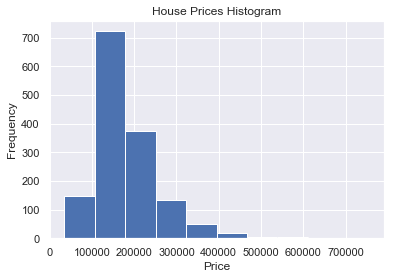

In [55]:
#view the target variable as a histogram

plt.hist(house_prices_df.saleprice)
plt.title("House Prices Histogram")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

The histogram of House Prices is not normally distributed, but instead is skewed right.

In [24]:
#examine the data frame

print(
    house_prices_df.head(),
    house_prices_df.info(),
    house_prices_df.describe()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [22]:
#determine which variables have missing values and in what percentage

missing_values_ratios = (house_prices_df.isnull().sum()/house_prices_df.isnull().count())
missing_values_ratios.sort_values(ascending=False).head(30)

poolqc          0.995205
miscfeature     0.963014
alley           0.937671
fence           0.807534
fireplacequ     0.472603
lotfrontage     0.177397
garagecond      0.055479
garagetype      0.055479
garageyrblt     0.055479
garagefinish    0.055479
garagequal      0.055479
bsmtexposure    0.026027
bsmtfintype2    0.026027
bsmtfintype1    0.025342
bsmtcond        0.025342
bsmtqual        0.025342
masvnrarea      0.005479
masvnrtype      0.005479
electrical      0.000685
utilities       0.000000
yearremodadd    0.000000
mssubclass      0.000000
foundation      0.000000
extercond       0.000000
exterqual       0.000000
exterior2nd     0.000000
exterior1st     0.000000
roofmatl        0.000000
roofstyle       0.000000
yearbuilt       0.000000
dtype: float64

It appears that most of the columns are not missing data, so we will avoid using the ones that are.

In [62]:
#check the correlation of the numerical variables with the target
np.abs(house_prices_df[house_prices_df.select_dtypes(['int64', 'float64']).columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False).head(20)

saleprice       1.000000
overallqual     0.790982
grlivarea       0.708624
garagecars      0.640409
garagearea      0.623431
totalbsmtsf     0.613581
firstflrsf      0.605852
fullbath        0.560664
totrmsabvgrd    0.533723
yearbuilt       0.522897
yearremodadd    0.507101
garageyrblt     0.486362
masvnrarea      0.477493
fireplaces      0.466929
bsmtfinsf1      0.386420
lotfrontage     0.351799
wooddecksf      0.324413
secondflrsf     0.319334
openporchsf     0.315856
halfbath        0.284108
Name: saleprice, dtype: float64

## Run your house prices model again and assess the goodness of fit of your model using F-test, R-squared, adjusted R-squared, AIC and BIC.

In [60]:
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf']]
Y = house_prices_df.saleprice

In [61]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1156.
Date:                Tue, 23 Jul 2019   Prob (F-statistic):               0.00
Time:                        17:19:40   Log-Likelihood:                -17500.
No. Observations:                1460   AIC:                         3.501e+04
Df Residuals:                    1455   BIC:                         3.504e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.925e+04   4639.866    -21.390      0.000   -1.08e+05   -9.01e+04
overallqual  2.357e+04   1072.465     21.980      0.000    2.15e+04    2.57e+04
grlivarea      45.6432      2.484     18.376      0.000      40.771      50.515
garagecars   1.858e+04   1747.412     10.634      0.000    1.52e+04     2.2e+04
totalbsmtsf    32.5203      2.838     11.459      0.000      26.953      38.087
==============================================================================
Omnibus:                      421.692   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36798.858
Skew:                          -0.273   Prob(JB):                         0.00
Kurtosis:                      27.589   Cond. No.                     8.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model has an adjusted R-squared value of 0.760, which is not terrible.  The F-statisitic p-value is 0, which means that the model is performing better than an empty model.  AIC and BIC are 3.501e+04 and 3.504e+04, respectively.

## Do you think your model is satisfactory? If so, why?

I don't know- the R-squared value could be higher, and the AIC and BIC scores seem rather large. 

## In order to improve the goodness of fit of your model, try different model specifications by adding or removing some variables.

In [63]:
#here we add an interaction variable
house_prices_df['year_by_year'] = house_prices_df.yearbuilt * house_prices_df.yearremodadd

X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'year_by_year']]
Y = house_prices_df.saleprice

In [64]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     978.4
Date:                Tue, 23 Jul 2019   Prob (F-statistic):               0.00
Time:                        17:50:03   Log-Likelihood:                -17468.
No. Observations:                1460   AIC:                         3.495e+04
Df Residuals:                    1454   BIC:                         3.498e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.514e+05   5.64e+04     -9.781      0.000   -6.62e+05   -4.41e+05
overallqual   1.913e+04   1186.087     16.128      0.000    1.68e+04    2.15e+04
grlivarea       50.6553      2.510     20.184      0.000      45.732      55.578
garagecars    1.422e+04   1794.181      7.926      0.000    1.07e+04    1.77e+04
totalbsmtsf     30.6398      2.788     10.991      0.000      25.172      36.108
year_by_year     0.1230      0.015      8.047      0.000       0.093       0.153
==============================================================================
Omnibus:                      441.569   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48687.481
Skew:                          -0.263   Prob(JB):                         0.00
Kurtosis:                      31.285   Cond. No.                     2.21e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared values as well as the AIC and BIC scores have improved a bit in this model.  However, the condition number has increased by several orders of magnitude (The modules have not mentioned about condition numbers, but it seems like it might be worth wondering about)

## For each model you try, get the goodness of fit metrics and compare your models with each other. Which model is the best and why?

The second model seems better based on the metrics covered in this checkpoint.